In [1]:
import sys

import pandas as pd
import mplfinance as mpl

sys.path.append("../../")
sys.path.append(".")

from strategy import LongStrategy, ShortStrategy
from triple_barrier.trading import DataSetLabeler
from triple_barrier.trade_labeling import TradeSide
from triple_barrier.trading import TradingParameters

# Constants

In [2]:
FAST_PERIODS: int = 10
COLUMNS = ["date-time", "open", "high", "low", "close", "volume"]
SLOW_PERIODS: int = 20

# Using triple barrier from pandas apply

The following examples show how to use triple barrier to massively label trades using as input a pandas dataframe that contains enty and eventually custom exit signals.

## Trading Strategy

In this section is described how to implement a simple trading strategy that generates the inputs for triple_barrier.

- The calculations are performed on a OHLC time series.
- The price used is FOREX and for now the triple barrier is tested onbly on forex price.


The strategy is as follows:

1. Two moving averages are calculated: 10 periods ( called FAST ), the fast one, and 20 periods one (called SLOW) the slow one
2. A long signal is recorded for a bar after the closing if the following condition is met: FAST crosses above SLOW. More precisely:

$FAST_{t-1} < SLOW_{t-1} \land FAST_t > SLOW_t$

Where:

- $t-1$: period previous to the current closing
- $t$: current closing period

3. A short signal is recorded for a bar after the closing if the following condition is met FAST crosses below SLOW. More precisely:

$FAST_{t-1} > SLOW_{t-1} \land FAST_t < SLOW_t$

Where:

- $t-1$: period previous to the current closing
- $t$: current closing period


Notes

The entry period, when the position is opened, is the period right after the signal, the position open price is the open price for this bar.

Position opening price = $open_t$

For closing there will be a few cases that will be setup using the triple barrier and will be described in the caseses next. One of the closing cases is closing when the enrey condition is not valid anymorre and is described next.


4. Long closing: FAST < SLOW
5. Short closing: FAST > SLOW


### Long Strategy

In [3]:
price = pd.read_csv("../../tests/data/EURUSD_5 Mins_Ask_2023.01.02_2024.02.02.csv", parse_dates=True, names=COLUMNS, index_col="date-time", header=0)
price.head()

,open,high,low,close,volume
date-time,,,,,
2023-01-02 00:00:00,1.07005,1.07013,1.06985,1.06986,136.06
2023-01-02 00:05:00,1.06986,1.06991,1.06980,1.06981,66.84
2023-01-02 00:10:00,1.07009,1.07011,1.06976,1.06986,118.38
2023-01-02 00:15:00,1.06986,1.07012,1.06985,1.06986,117.64
2023-01-02 00:20:00,1.06986,1.07014,1.06985,1.07011,141.48


In [4]:
long_strategy = LongStrategy(pip_position=4)
long_strategy.calculate(price, fast_periods=10, slow_periods=20)
price.head()

,open,high,low,close,volume,mva-10,mva-20,long-signal,long-entry,long-signal-plot,long-entry-plot
date-time,,,,,,,,,,,
2023-01-02 01:35:00,1.07053,1.07061,1.07044,1.07054,603.66,1.07042,1.07020,NaN,NaN,NaN,NaN
2023-01-02 01:40:00,1.07053,1.07058,1.07046,1.07046,265.02,1.07047,1.07023,NaN,NaN,NaN,NaN
2023-01-02 01:45:00,1.07046,1.07058,1.07045,1.07057,198.36,1.07052,1.07027,NaN,NaN,NaN,NaN
2023-01-02 01:50:00,1.07055,1.07060,1.07051,1.07057,278.28,1.07053,1.07030,NaN,NaN,NaN,NaN
2023-01-02 01:55:00,1.07057,1.07061,1.07046,1.07047,348.78,1.07054,1.07034,NaN,NaN,NaN,NaN


In [5]:
price.loc["2023-01-02 14:25:00":"2023-01-02 14:45:00"]

,open,high,low,close,volume,mva-10,mva-20,long-signal,long-entry,long-signal-plot,long-entry-plot
date-time,,,,,,,,,,,
2023-01-02 14:25:00,1.06609,1.06621,1.06606,1.06610,322.26,1.06587,1.06595,NaN,NaN,NaN,NaN
2023-01-02 14:30:00,1.06610,1.06614,1.06601,1.06608,237.61,1.06593,1.06593,NaN,NaN,NaN,NaN
2023-01-02 14:35:00,1.06608,1.06618,1.06607,1.06610,117.80,1.06600,1.06593,1.0,NaN,1.06557,NaN
2023-01-02 14:40:00,1.06611,1.06620,1.06611,1.06612,189.59,1.06604,1.06592,NaN,1.0,NaN,1.06561
2023-01-02 14:45:00,1.06613,1.06617,1.06605,1.06613,215.13,1.06609,1.06590,NaN,NaN,NaN,NaN


In the table above, you can see an examplem of FAST crossing above SLOW, which triggers a long signal and marks the next bar as long entry

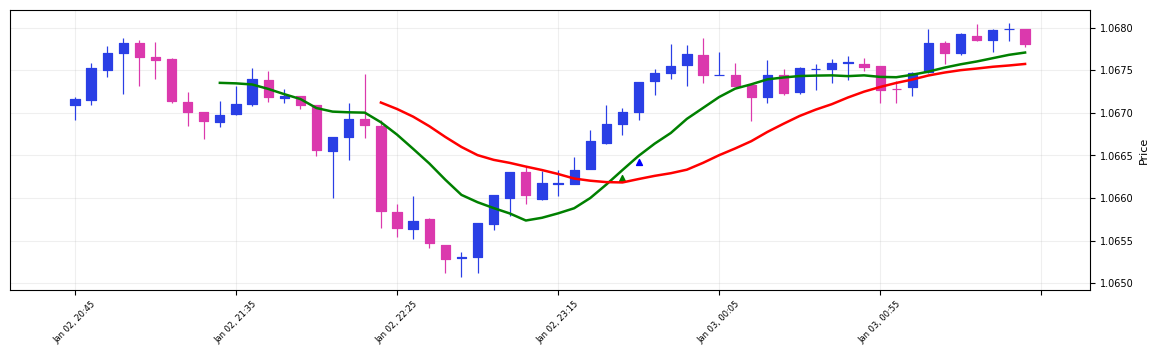

In [6]:
ap0 = [ mpl.make_addplot(price.loc["2023-01-02 20:45:00": "2023-01-03 01:40:00"]['long-signal-plot'],color='g', marker="^", type="scatter"),  # uses panel 0 by default
        mpl.make_addplot(price.loc["2023-01-02 20:45:00": "2023-01-03 01:40:00"]['long-entry-plot'],color='b', marker="^", type="scatter"),]  # uses panel 0 by default 

mpl.plot(price.loc["2023-01-02 20:45:00": "2023-01-03 01:40:00"], type="candle", figsize=(15,4), style="ibd", addplot=ap0, mav=(FAST_PERIODS, SLOW_PERIODS))

In [7]:


trade_params = TradingParameters(
    open_price=price.open,
    high_price=price.high,
    low_price=price.low,
    close_price=price.close,
    entry_mark=price["long-entry"],
    stop_loss_width=10,
    take_profit_width=20,
    trade_side=TradeSide.BUY,
    pip_decimal_position=4,
    time_barrier_periods=2,
    dynamic_exit=None
)

dataset_labeler = DataSetLabeler(trade_params)
trades: pd.DataFrame = dataset_labeler.compute()

In [8]:
trades.head()

,open,high,low,close,entry,close-price,close-datetime,close-type,profit
date-time,,,,,,,,,
2023-01-02 14:40:00,1.06611,1.06620,1.06611,1.06612,1.0,1.06611,2023-01-02 14:50:00,time-expiration,0.0
2023-01-02 17:00:00,1.06601,1.06626,1.06577,1.06600,1.0,1.06620,2023-01-02 17:10:00,time-expiration,1.9
2023-01-02 20:05:00,1.06810,1.06840,1.06805,1.06810,1.0,1.06710,2023-01-02 20:10:00,stop-loss,-10.0
2023-01-02 20:40:00,1.06696,1.06747,1.06693,1.06713,1.0,1.06715,2023-01-02 20:50:00,time-expiration,1.9
2023-01-02 23:40:00,1.06701,1.06736,1.06692,1.06736,1.0,1.06747,2023-01-02 23:50:00,time-expiration,4.6


<Axes: xlabel='date-time'>

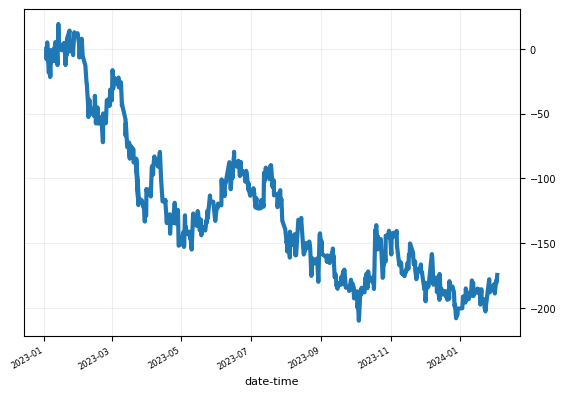

In [9]:
trades["profit"].cumsum().plot()

### Short Strategy

In [10]:
price = pd.read_csv("../../tests/data/EURUSD_5 Mins_Ask_2023.01.02_2024.02.02.csv", parse_dates=True, names=COLUMNS, index_col="date-time", header=0)
price.head()

,open,high,low,close,volume
date-time,,,,,
2023-01-02 00:00:00,1.07005,1.07013,1.06985,1.06986,136.06
2023-01-02 00:05:00,1.06986,1.06991,1.06980,1.06981,66.84
2023-01-02 00:10:00,1.07009,1.07011,1.06976,1.06986,118.38
2023-01-02 00:15:00,1.06986,1.07012,1.06985,1.06986,117.64
2023-01-02 00:20:00,1.06986,1.07014,1.06985,1.07011,141.48


In [11]:
long_strategy = ShortStrategy(pip_position=4)
long_strategy.calculate(price, fast_periods=10, slow_periods=20)
price.head()

,open,high,low,close,volume,mva-10,mva-20,short-signal,short-entry,short-signal-plot,short-entry-plot
date-time,,,,,,,,,,,
2023-01-02 01:35:00,1.07053,1.07061,1.07044,1.07054,603.66,1.07042,1.07020,NaN,NaN,NaN,NaN
2023-01-02 01:40:00,1.07053,1.07058,1.07046,1.07046,265.02,1.07047,1.07023,NaN,NaN,NaN,NaN
2023-01-02 01:45:00,1.07046,1.07058,1.07045,1.07057,198.36,1.07052,1.07027,NaN,NaN,NaN,NaN
2023-01-02 01:50:00,1.07055,1.07060,1.07051,1.07057,278.28,1.07053,1.07030,NaN,NaN,NaN,NaN
2023-01-02 01:55:00,1.07057,1.07061,1.07046,1.07047,348.78,1.07054,1.07034,NaN,NaN,NaN,NaN


In [12]:
range_from = "2023-01-02 13:00:00"
range_to = "2023-01-02 16:00:00"

In [13]:
price.loc[range_from:range_to].tail(10)

,open,high,low,close,volume,mva-10,mva-20,short-signal,short-entry,short-signal-plot,short-entry-plot
date-time,,,,,,,,,,,
2023-01-02 15:15:00,1.06573,1.06582,1.06570,1.06573,204.30,1.06601,1.06594,NaN,NaN,NaN,NaN
2023-01-02 15:20:00,1.06573,1.06575,1.06549,1.06550,45.00,1.06595,1.06594,NaN,NaN,NaN,NaN
2023-01-02 15:25:00,1.06553,1.06573,1.06532,1.06533,68.46,1.06587,1.06593,1.0,NaN,1.06623,NaN
2023-01-02 15:30:00,1.06533,1.06574,1.06533,1.06550,44.11,1.06581,1.06593,NaN,1.0,NaN,1.06624
2023-01-02 15:35:00,1.06550,1.06556,1.06537,1.06551,69.06,1.06575,1.06592,NaN,NaN,NaN,NaN
2023-01-02 15:40:00,1.06550,1.06550,1.06534,1.06536,8.21,1.06567,1.06588,NaN,NaN,NaN,NaN
2023-01-02 15:45:00,1.06536,1.06542,1.06534,1.06542,4.61,1.06560,1.06584,NaN,NaN,NaN,NaN
2023-01-02 15:50:00,1.06542,1.06542,1.06536,1.06540,22.93,1.06554,1.06581,NaN,NaN,NaN,NaN
2023-01-02 15:55:00,1.06540,1.06540,1.06532,1.06533,21.96,1.06548,1.06578,NaN,NaN,NaN,NaN


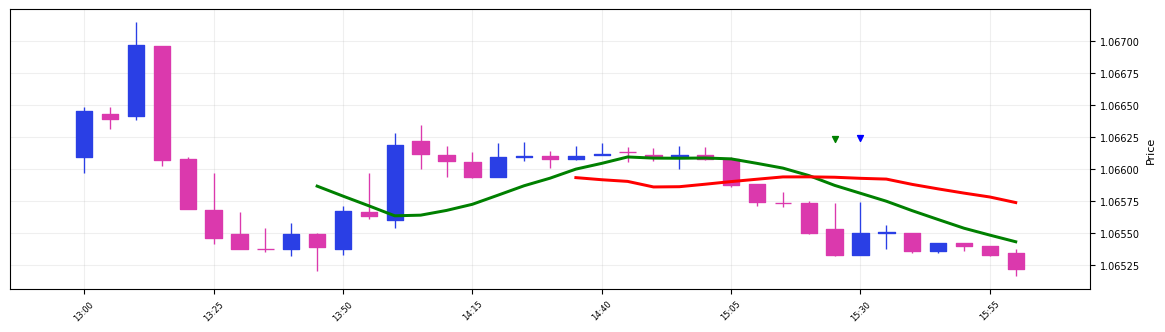

In [14]:
ap0 = [ mpl.make_addplot(price.loc[range_from:range_to]['short-signal-plot'],color='g', marker="v", type="scatter"),  # uses panel 0 by default
        mpl.make_addplot(price.loc[range_from:range_to]['short-entry-plot'],color='b', marker="v", type="scatter"),]  # uses panel 0 by default 

mpl.plot(price.loc[range_from:range_to], type="candle", figsize=(15,4), style="ibd", addplot=ap0, mav=(FAST_PERIODS, SLOW_PERIODS))

In [21]:
trade_params = TradingParameters(
    open_price=price.open,
    high_price=price.high,
    low_price=price.low,
    close_price=price.close,
    entry_mark=price["short-entry"],
    stop_loss_width=20,
    take_profit_width=40,
    trade_side=TradeSide.SELL,
    pip_decimal_position=4,
    time_barrier_periods=10,
    dynamic_exit=None
)

dataset_labeler = DataSetLabeler(trade_params)
trades: pd.DataFrame = dataset_labeler.compute()

In [22]:
trades.head()

,open,high,low,close,entry,close-price,close-datetime,close-type,profit
date-time,,,,,,,,,
2023-01-02 02:25:00,1.06939,1.06976,1.06939,1.06961,1.0,1.06967,2023-01-02 03:15:00,time-expiration,-2.8
2023-01-02 10:10:00,1.06827,1.06834,1.06795,1.06830,1.0,1.06796,2023-01-02 11:00:00,time-expiration,3.1
2023-01-02 15:30:00,1.06533,1.06574,1.06533,1.06550,1.0,1.06529,2023-01-02 16:20:00,time-expiration,0.4
2023-01-02 22:05:00,1.06655,1.06672,1.06600,1.06672,1.0,1.06569,2023-01-02 22:55:00,time-expiration,8.6
2023-01-03 02:10:00,1.06675,1.06698,1.06675,1.06681,1.0,1.06639,2023-01-03 03:00:00,time-expiration,3.6


<Axes: xlabel='date-time'>

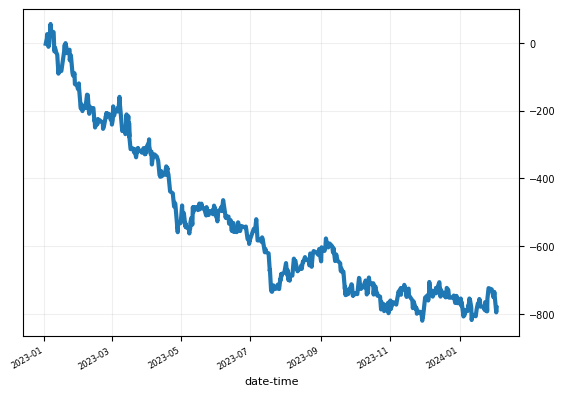

In [23]:
trades["profit"].cumsum().plot()